# DCGANs

Introduction to **Deep Convolutional Generative Adversarial Networks** or DCGANs. 

This notebook is organized as follows:

1. **Background**
2. **Definition**
3. **Training DCGANs with Keras and TensorFlow**

---

## 1. Background

Brief definition of some concepts, such as convolution and Convolutional Neural Network (CNN).

### Convolution

Convolution is a mathematical operation which describes a rule of how to mix two functions or pieces of information.

* Features Map $I$
* Convolution kernel $K$
* Map of transformed features $S(i, j)$

![convolution](https://devblogs.nvidia.com/wp-content/uploads/2015/11/convolution.png)

### Convolutional Neural Network (CNN)

Convolutional networks are simply neural networks that use convolution in place of general matrix multiplication in at least one of their layers.

These convolutional layers have parameters that are learned so that these filters are adjusted automatically to extract the most useful information for the task at hand.

* Input is a multidimensional array of data,
* Kernel is a multidimensional array of parameters,
* These multidimensional arrays are tensors.

#### Layers CNN

* Convolution: extract features from imagem.
* Pooling: reduce dimension of entry.
* Dense / Fully connected: connect the layers.

## 2. Definition

The difference between the simple GAN and the DCGAN, is the generator of the simple GAN is a simple fully connected network. The generator of the DCGAN uses the transposed convolution (Fractionally-strided convolution or 
Deconvolution) technique to perform up-sampling of 2D image size.



## 3. Training DCGANs with Keras and TensorFlow

A DCGANs implementation using the transposed convolution technique and the [Keras](https://keras.io/) library.


### 1. Load data

#### Load libraries

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model
from keras import backend as K

Using TensorFlow backend.


#### Getting the data

In [3]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#### Explore visual data

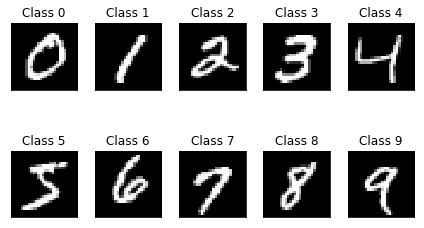

In [4]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [5]:
print('X_train.shape', X_train.shape)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
X_train reshape: (60000, 28, 28, 1)


### 2. Define model

#### Generator

Our generator using the **inverse of convolution**, called transposed convolution. 

In between layers, BatchNormalization stabilizes learning. 

The activation function after each layer is a LeakyReLU. 

The output of the tanh at the last layer produces the fake image. 

![generator model](../img/generative.png)

In [6]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# FC: 7x7x256
generator.add(Dense(7*7*128, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(Reshape((7, 7, 128)))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# # Conv 1: 14x14x128
generator.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 2: 28x28x64
generator.add(Conv2DTranspose(32, kernel_size=3, strides=1, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 3: 28x28x32
generator.add(Conv2DTranspose(32, kernel_size=3, strides=1, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 4: 28x28x1
generator.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same',
                              activation='tanh'))

#### Generator model visualization

In [7]:
# prints a summary representation of your model
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        73792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
__________

#### Discriminator

Our discriminator is a **convolutional neural network** that takes a 28x28 image with 1 channel. The values in the image is expected to be between -1 and 1.

It takes a digit image and classifies whether an image is real (1) or not (0).

The last activation is sigmoid to tell us the probability of whether the input image is real or not.

![discriminator model](../img/discriminative.png)

In [8]:
# Discriminator network
discriminator = Sequential()

# Conv 1: 14x14x64
discriminator.add(Conv2D(32, kernel_size=3, strides=2, padding='same',
                         input_shape=(28, 28, 1), kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding='same'))
discriminator.add(LeakyReLU(0.2))

# FC
discriminator.add(Flatten())
discriminator.add(LeakyReLU(0.2))

# Output
discriminator.add(Dense(1, activation='sigmoid'))

#### Discriminator model visualization

In [9]:
# prints a summary representation of your model
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 512)         590336    
__________

### 3. Compile model

#### Compile discriminator

In [10]:
# Optimizer
opt = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(opt, loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

#### Combined network

We connect the generator and the discriminator to make a DCGAN.

In [11]:
# d_g = discriminador(generador(z))
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

d_g.compile(opt, loss='binary_crossentropy',
            metrics=['binary_accuracy'])

#### GAN model vizualization

In [12]:
# prints a summary representation of your model
d_g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         736289    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 691201    
Total params: 1,427,490
Trainable params: 735,777
Non-trainable params: 691,713
_________________________________________________________________


### 4. Fit model

We train the discriminator and the generator in turn in a loop as follows:

1. Set the discriminator trainable
2. Train the discriminator with the real digit images and the images generated by the generator to classify the real and fake images.
3. Set the discriminator non-trainable
4. Train the generator as part of the GAN. We feed latent samples into the GAN and let the generator to produce digit images and use the discriminator to classify the image.

epoch = 1/100, d_loss=0.564, g_loss=1.352                                                                                                                      


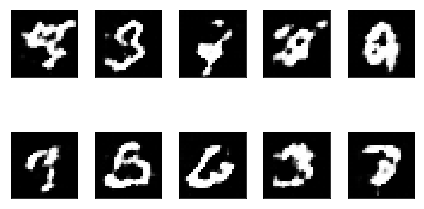

epoch = 2/100, d_loss=0.600, g_loss=1.044                                                                                                                      
epoch = 3/100, d_loss=0.596, g_loss=1.077                                                                                                                      
epoch = 4/100, d_loss=0.581, g_loss=1.143                                                                                                                      
epoch = 5/100, d_loss=0.526, g_loss=1.282                                                                                                                      
epoch = 6/100, d_loss=0.539, g_loss=1.287                                                                                                                      
epoch = 7/100, d_loss=0.506, g_loss=1.334                                                                                                                      
epoch = 8/100, d_loss=0.498, g_loss=1.37

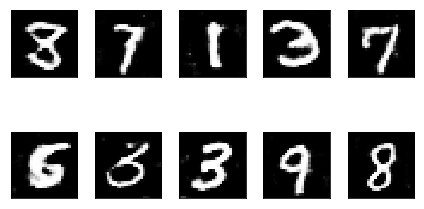

epoch = 12/100, d_loss=0.464, g_loss=1.612                                                                                                                      
epoch = 13/100, d_loss=0.463, g_loss=1.779                                                                                                                      
epoch = 14/100, d_loss=0.419, g_loss=1.842                                                                                                                      
epoch = 15/100, d_loss=0.468, g_loss=1.630                                                                                                                      
epoch = 16/100, d_loss=0.398, g_loss=1.940                                                                                                                      
epoch = 17/100, d_loss=0.446, g_loss=1.852                                                                                                                      
epoch = 18/100, d_loss=0.474, g_lo

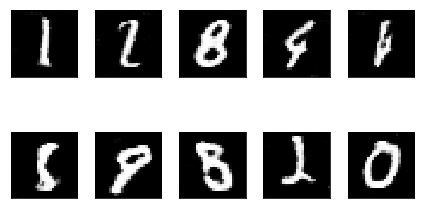

epoch = 22/100, d_loss=0.395, g_loss=2.182                                                                                                                      
epoch = 23/100, d_loss=0.432, g_loss=1.955                                                                                                                      
epoch = 24/100, d_loss=0.465, g_loss=1.891                                                                                                                      
epoch = 25/100, d_loss=0.404, g_loss=2.106                                                                                                                      
epoch = 26/100, d_loss=0.392, g_loss=2.096                                                                                                                      
epoch = 27/100, d_loss=0.436, g_loss=1.934                                                                                                                      
epoch = 28/100, d_loss=0.403, g_lo

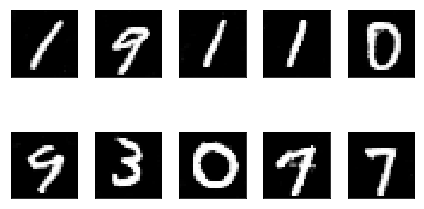

epoch = 32/100, d_loss=0.491, g_loss=2.004                                                                                                                      
epoch = 33/100, d_loss=0.426, g_loss=2.283                                                                                                                      
epoch = 34/100, d_loss=0.373, g_loss=2.407                                                                                                                      
epoch = 35/100, d_loss=0.406, g_loss=2.285                                                                                                                      
epoch = 36/100, d_loss=0.415, g_loss=2.382                                                                                                                      
epoch = 37/100, d_loss=0.395, g_loss=2.379                                                                                                                      
epoch = 38/100, d_loss=0.427, g_lo

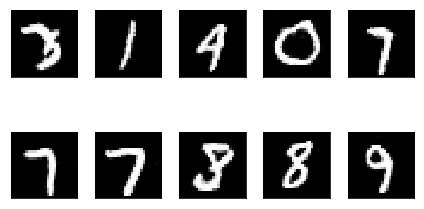

epoch = 42/100, d_loss=0.396, g_loss=2.755                                                                                                                      
epoch = 43/100, d_loss=0.374, g_loss=2.514                                                                                                                      
epoch = 44/100, d_loss=0.382, g_loss=2.768                                                                                                                      
epoch = 45/100, d_loss=0.398, g_loss=2.747                                                                                                                      
epoch = 46/100, d_loss=0.357, g_loss=2.727                                                                                                                      
epoch = 47/100, d_loss=0.392, g_loss=2.542                                                                                                                      
epoch = 48/100, d_loss=0.378, g_lo

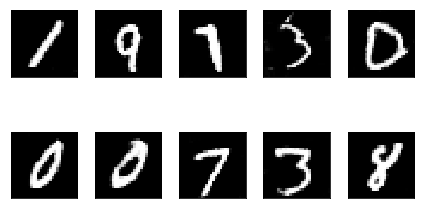

epoch = 52/100, d_loss=0.341, g_loss=3.188                                                                                                                      
epoch = 53/100, d_loss=0.348, g_loss=3.070                                                                                                                      
epoch = 54/100, d_loss=0.362, g_loss=2.751                                                                                                                      
epoch = 55/100, d_loss=0.355, g_loss=3.117                                                                                                                      
epoch = 56/100, d_loss=0.360, g_loss=2.861                                                                                                                      
epoch = 57/100, d_loss=0.371, g_loss=3.031                                                                                                                      
epoch = 58/100, d_loss=0.368, g_lo

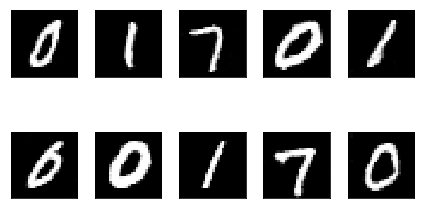

epoch = 62/100, d_loss=0.348, g_loss=3.533                                                                                                                      
epoch = 63/100, d_loss=0.334, g_loss=3.567                                                                                                                      
epoch = 64/100, d_loss=0.381, g_loss=3.128                                                                                                                      
epoch = 65/100, d_loss=0.331, g_loss=3.634                                                                                                                      
epoch = 66/100, d_loss=0.344, g_loss=3.608                                                                                                                      
epoch = 67/100, d_loss=0.302, g_loss=3.611                                                                                                                      
epoch = 68/100, d_loss=0.333, g_lo

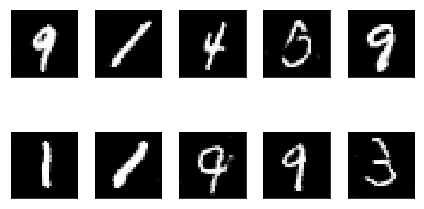

epoch = 72/100, d_loss=0.277, g_loss=3.961                                                                                                                      
epoch = 73/100, d_loss=0.302, g_loss=3.973                                                                                                                      
epoch = 74/100, d_loss=0.300, g_loss=3.935                                                                                                                      
epoch = 75/100, d_loss=0.345, g_loss=3.860                                                                                                                      
epoch = 76/100, d_loss=0.313, g_loss=3.545                                                                                                                      
epoch = 77/100, d_loss=0.335, g_loss=4.023                                                                                                                      
epoch = 78/100, d_loss=0.256, g_lo

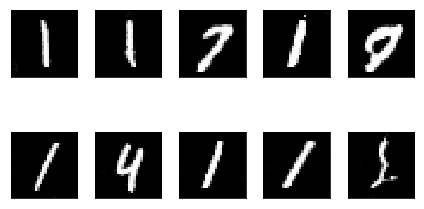

epoch = 82/100, d_loss=0.276, g_loss=4.238                                                                                                                      
epoch = 83/100, d_loss=0.293, g_loss=4.349                                                                                                                      
epoch = 84/100, d_loss=0.313, g_loss=3.817                                                                                                                      
epoch = 85/100, d_loss=0.303, g_loss=3.656                                                                                                                      
epoch = 86/100, d_loss=0.347, g_loss=3.719                                                                                                                      
epoch = 87/100, d_loss=0.255, g_loss=4.288                                                                                                                      
epoch = 88/100, d_loss=0.242, g_lo

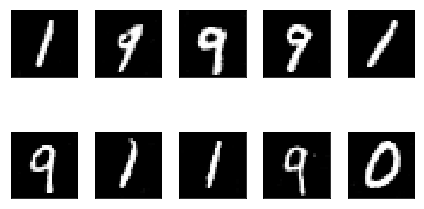

epoch = 92/100, d_loss=0.236, g_loss=4.315                                                                                                                      
epoch = 93/100, d_loss=0.240, g_loss=4.284                                                                                                                      
epoch = 94/100, d_loss=0.287, g_loss=4.254                                                                                                                      
epoch = 95/100, d_loss=0.245, g_loss=4.609                                                                                                                      
epoch = 96/100, d_loss=0.272, g_loss=5.056                                                                                                                      
epoch = 97/100, d_loss=0.275, g_loss=4.452                                                                                                                      
epoch = 98/100, d_loss=0.238, g_lo

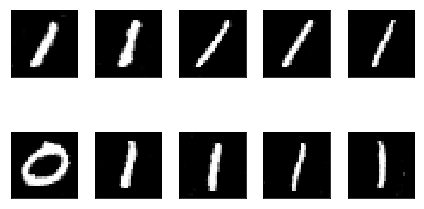

In [13]:
epochs = 100
batch_size = 64
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch,
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

### 5. Evaluate model

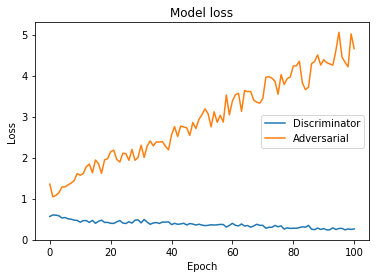

In [14]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

## References

* [Generative Adversarial Networks or GANs](https://arxiv.org/abs/1406.2661)
* [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
* [THE MNIST DATABASE of handwritten digits](http://yann.lecun.com/exdb/mnist/)
* [Convolution](https://devblogs.nvidia.com/deep-learning-nutshell-core-concepts/)